In [1]:
#Package import

import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import requests

pd.options.display.max_rows=500
pd.options.display.min_rows=500
pd.options.display.max_columns=500
pd.options.display.max_colwidth=500

In [2]:
# Loading play-by-play data from 2015-2023. Year chosen due to standardized extra point distance. 
# Data includes all kicks for these years, and all kicker statistics will take all kicks these kickers took in these years. 
# Data from https://nflsavant.com/about.php

base={}
pbp=pd.DataFrame()

domain = "https://nflsavant.com/pbp_data.php?year="
prefix="pbp-"
ext=".csv"

for i in range(2015, 2024):
    url = domain + str(i)
    file_response = requests.get(url)
    file_response.raise_for_status()

    filename = prefix + str(i)+ext
    with open(filename, 'wb') as f:
        f.write(file_response.content)

    base[i] = pd.read_csv(filename)
    pbp = pd.concat([pbp, base[i]]).reset_index(drop=True)

In [3]:
# Finding all extra points in the play-by-play data and cleaning the data

pbpxp = pbp.loc[(pbp['PlayType'] == 'EXTRA POINT') & (pbp['GameDate'].str.contains('2014-') == False)].reset_index(drop=True)
pbpxp.loc[(pbpxp['Description'].str.contains('(KICK FORMATION)'), 'Kicker')] = pbpxp['Description'].str.split(")").str[1].str.split(" ").str[1]
pbpxp.loc[(pbpxp['Description'].str.contains('(KICK FORMATION)') == False, 'Kicker')] =  pbpxp['Description'].str.split(' ').str[0]
pbpxp.loc[pbpxp['Description'].str.contains('IS GOOD'), 'isGOOD'] = 1
pbpxp.loc[pbpxp['Description'].str.contains('IS GOOD') == False, 'isGOOD'] = 0
pbpxp['Kicker_Name'] = pbpxp['Kicker'].str.split('-').str[1]
for idx, i in enumerate(pbpxp['GameDate']):
    if float(i.split('-')[1])<3:
        pbpxp.at[idx, 'Season'] = float(i.split('-')[0]) - 1
    else:
        pbpxp.at[idx, 'Season'] = float(i.split('-')[0])
pbpxp['Season_Kicker'] = pbpxp['Kicker_Name'] + pbpxp['Season'].astype(str)

#Grouping all kickers together and finding their XP%
extrapoints = pbpxp.groupby('Kicker_Name').agg({'isGOOD':sum, 'Description':'count'}).reset_index(drop=False)
extrapoints = extrapoints.rename(columns = {'isGOOD':'Makes', 'Description':'Attempts'})
extrapoints['Kick_%'] = extrapoints['Makes'] / extrapoints['Attempts']

# NFL offenses average 36.5 extra points in a season

avg_xps = 36.5
extrapoints['ExtraPoints_Per_Season_Prorated'] = extrapoints['Kick_%'] * avg_xps

C:\Users\patrick.powers\AppData\Local\Temp\ipykernel_31912\590752070.py:4: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  pbpxp.loc[(pbpxp['Description'].str.contains('(KICK FORMATION)'), 'Kicker')] = pbpxp['Description'].str.split(")").str[1].str.split(" ").str[1]
C:\Users\patrick.powers\AppData\Local\Temp\ipykernel_31912\590752070.py:5: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  pbpxp.loc[(pbpxp['Description'].str.contains('(KICK FORMATION)') == False, 'Kicker')] =  pbpxp['Description'].str.split(' ').str[0]
C:\Users\patrick.powers\AppData\Local\Temp\ipykernel_31912\590752070.py:17: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instea

In [4]:
# Finding all field goals in the play-by-play data and cleaning the data

pbpfg = pbp.loc[(pbp['PlayType'] == 'FIELD GOAL') & (pbp['GameDate'].str.contains('2014-') == False)].reset_index(drop=True)
pbpfg.loc[(pbpfg['Description'].str.contains('(FIELD GOAL FORMATION)'), 'Kicker')] = pbpfg['Description'].str.split(')').str[2].str.split(' ').str[1]
pbpfg.loc[(pbpfg['Description'].str.contains('(FIELD GOAL FORMATION)') == False, 'Kicker')] =  pbpfg['Description'].str.split(' ').str[1]
pbpfg.loc[pbpfg['Description'].str.contains('IS GOOD'), 'isGOOD'] = 1
pbpfg.loc[pbpfg['Description'].str.contains('IS GOOD') == False, 'isGOOD'] = 0
pbpfg.loc[(pbpfg['Kicker'] == '60'), 'Kicker'] = "4-J-SLYE"
pbpfg.loc[(pbpfg['Kicker'] == '#79'), 'Kicker'] = "2-N.FOLK"
pbpfg.loc[(pbpfg['Kicker'] == '(NO') & (pbpfg['OffenseTeam'] == 'CHI'), 'Kicker'] = "1-M.NUGENT"
pbpfg.loc[(pbpfg['Kicker'] == '(NO') & (pbpfg['OffenseTeam'] == 'DEN'), 'Kicker'] = "8-B.MCMANUS"
pbpfg['Distance'] = pbpfg['Description'].str.split(' YARD FIELD GOAL').str[0].str.split(' ').str[-1]
pbpfg.loc[(pbpfg['Distance'].str.contains('13')), 'Distance'] = 0
pbpfg['Distance'] = pbpfg['Distance'].astype(float)
pbpfg['Kicker_Name'] = pbpfg['Kicker'].str.split('-').str[1]
pbpfg.loc[(pbpfg['Kicker_Name'] == 'J'), 'Kicker'] = '4-J.SLYE'
pbpfg.loc[(pbpfg['Kicker_Name'] == 'J'), 'Kicker_Name'] = 'J.SLYE'
for idx, i in enumerate(pbpfg['GameDate']):
    if float(i.split('-')[1])<3:
        pbpfg.at[idx, 'Season'] = float(i.split('-')[0]) - 1
    else:
        pbpfg.at[idx, 'Season'] = float(i.split('-')[0])
pbpfg['Season_Kicker'] = pbpfg['Kicker_Name'] + pbpfg['Season'].astype(str)

C:\Users\patrick.powers\AppData\Local\Temp\ipykernel_31912\3684178423.py:4: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  pbpfg.loc[(pbpfg['Description'].str.contains('(FIELD GOAL FORMATION)'), 'Kicker')] = pbpfg['Description'].str.split(')').str[2].str.split(' ').str[1]
C:\Users\patrick.powers\AppData\Local\Temp\ipykernel_31912\3684178423.py:5: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  pbpfg.loc[(pbpfg['Description'].str.contains('(FIELD GOAL FORMATION)') == False, 'Kicker')] =  pbpfg['Description'].str.split(' ').str[1]


In [5]:
# Creating a smoothed function to find the average FG% by FG distance

fgdist = pbpfg.groupby('Distance').agg({'isGOOD':sum, 'Description':'count'}).reset_index(drop=False)
fgdist = fgdist.rename(columns = {'isGOOD':'Makes', 'Description':'Attempts'})
fgdist['Kick_%'] = fgdist['Makes'] / fgdist['Attempts']
fgdist['Kick_%_Smooth'] = (fgdist['Makes'].shift(-2) + fgdist['Makes'].shift(-1) + fgdist['Makes'].shift(0) + fgdist['Makes'].shift(1) + fgdist['Makes'].shift(2)) / (fgdist['Attempts'].shift(-2) + fgdist['Attempts'].shift(-1) + fgdist['Attempts'].shift(0) + fgdist['Attempts'].shift(1) + fgdist['Attempts'].shift(2))
fgdist.loc[(fgdist['Distance'] == 18), 'Kick_%_Smooth'] = 1
fgdist.loc[(fgdist['Distance'] >= 68), 'Kick_%_Smooth'] = 0
fgdist = fgdist.dropna(subset='Kick_%_Smooth').reset_index(drop=True)

C:\Users\patrick.powers\AppData\Local\Temp\ipykernel_31912\442372562.py:3: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  fgdist = pbpfg.groupby('Distance').agg({'isGOOD':sum, 'Description':'count'}).reset_index(drop=False)


In [6]:
# Creating an expected points column to compare how kickers did vs how they should have done

pbpfg = pd.merge(pbpfg, fgdist[['Distance', 'Kick_%_Smooth']], how = 'left', on = 'Distance')
pbpfg['expected_Pts'] = pbpfg['Kick_%_Smooth'] * 3
pbpfg['actual_Pts'] = pbpfg['isGOOD'] * 3
pbpfg['Residual'] = (pbpfg['isGOOD'] - pbpfg['Kick_%_Smooth'])
pbpfg['Residual_Points'] = (pbpfg['isGOOD'] - pbpfg['Kick_%_Smooth']) * 3

In [7]:
# Grouping all kickers together and finding their adjusted FG%

fieldgoals = pbpfg.groupby('Kicker_Name').agg({'isGOOD':sum, 'expected_Pts':sum, 'actual_Pts':'sum', 'Residual_Points':sum, 'Description':'count'}).reset_index(drop=False)
fieldgoals = fieldgoals.rename(columns = {'isGOOD':'Makes', 'Description':'Attempts'})
fieldgoals['FG_%'] = fieldgoals['Makes'] / fieldgoals['Attempts']
fieldgoals['Points_Per_FGA'] = (fieldgoals['actual_Pts'] / fieldgoals['Attempts'])
fieldgoals['Expected_Points_Per_FGA'] = (fieldgoals['expected_Pts'] / fieldgoals['Attempts'])
fieldgoals['Points_Per_FGA_Above_Expected'] = (fieldgoals['actual_Pts'] - fieldgoals['expected_Pts']) / fieldgoals['Attempts']
avg_fg = fieldgoals['actual_Pts'].sum() / fieldgoals['Attempts'].sum()
fieldgoals['Adjusted_Points_Per_FGA'] = fieldgoals['Points_Per_FGA_Above_Expected'] + avg_fg
fieldgoals['Adjusted_FG_%'] = (fieldgoals['Points_Per_FGA_Above_Expected'] + avg_fg) / 3

# NFL offenses average 31 field goals per season

avg_fgs = 31
fieldgoals['Points_Per_Season_Prorated'] = avg_fgs * fieldgoals['Points_Per_FGA']
fieldgoals['Adjusted_Points_Per_Season_Prorated'] = avg_fgs * fieldgoals['Adjusted_Points_Per_FGA']

C:\Users\patrick.powers\AppData\Local\Temp\ipykernel_31912\1999358711.py:3: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  fieldgoals = pbpfg.groupby('Kicker_Name').agg({'isGOOD':sum, 'expected_Pts':sum, 'actual_Pts':'sum', 'Residual_Points':sum, 'Description':'count'}).reset_index(drop=False)
C:\Users\patrick.powers\AppData\Local\Temp\ipykernel_31912\1999358711.py:3: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  fieldgoals = pbpfg.groupby('Kicker_Name').agg({'isGOOD':sum, 'expected_Pts':sum, 'actual_Pts':'sum', 'Residual_Points':sum, 'Description':'count'}).reset_index(drop=False)


In [8]:
# Merging the FGs and XPs and finding the Total Adjusted Points

all_kicks = pd.merge(fieldgoals, extrapoints, how = 'outer', on = 'Kicker_Name').reset_index(drop=True)
all_kicks = all_kicks.rename(columns = {'Makes_x':'FG_Makes', 'Attempts_x':'FG_Attempts', 'Kick_%_x':'FG_Kick_%', 'Makes_y':'XP_Makes', 'Attempts_y':'XP_Attempts', 'Kick_%_y':'XP_Kick_%'})
all_kicks['Total_Adjusted_Points'] = all_kicks['Adjusted_Points_Per_Season_Prorated'] + all_kicks['ExtraPoints_Per_Season_Prorated']

In [9]:
# Finding the value of a replacement kicker. Replacement-level kicker statistics taken from all kickers in each season
# from 2015-2024 who ranked below the top-32 kickers in the NFL in FG attempts in that season

replacement_kickers=pd.DataFrame()
for i in range(2015, 2024):
    pl=pbpfg.loc[(pbpfg['Season'] == i)].groupby('Season_Kicker')['Description'].count().reset_index().sort_values(by='Description', ascending=False).reset_index(drop=True)
    pl=pl.rename(columns = {'Description':'Attempts'})
    pl2=pl.iloc[32:]
    replacement_kickers=pd.concat([replacement_kickers, pl2])
    del pl
    del pl2
replacement_kickers=replacement_kickers.reset_index(drop=True)

In [10]:
# Finding the average seasonal value of the replacement-level kicker

replacement_kickers_fieldgoals = pd.merge(pbpfg, replacement_kickers, how='inner', on = 'Season_Kicker').reset_index(drop=True)
replacement_kickers_extrapoints = pd.merge(pbpxp, replacement_kickers, how='inner', on = 'Season_Kicker').reset_index(drop=True)
replacement_fg = (avg_fg + ((replacement_kickers_fieldgoals['actual_Pts'].sum() - replacement_kickers_fieldgoals['expected_Pts'].sum()) / len(replacement_kickers_fieldgoals['Attempts']))) * avg_fgs
replacement_xp = (replacement_kickers_extrapoints['isGOOD'].sum() / len(replacement_kickers_extrapoints)) * avg_xps

In [11]:
# Replacement kickers average 69.7 points in field goals, 32.6 in extra points, and 101 total points per season

print(replacement_fg)
print(replacement_xp)
print(replacement_fg + replacement_xp)

68.74966106537653
32.57310344827586
101.32276451365239


In [12]:
# Calculating each kicker's value above replacement-level kicker

all_kicks['Adjusted_Points_Per_Season_Prorated_Above_Replacement'] = all_kicks['Adjusted_Points_Per_Season_Prorated'] - replacement_fg
all_kicks['ExtraPoints_Per_Season_Prorated_Above_Replacement'] = all_kicks['ExtraPoints_Per_Season_Prorated'] - replacement_xp
all_kicks['Total_Adjusted_Points_Above_Replacement'] = all_kicks['Total_Adjusted_Points'] - replacement_fg - replacement_xp

In [13]:
# Scraping kicker salaries for the 2024 season

headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/89.0.4389.82 Safari/537.36',
    'Accept-Language': 'en-US,en;q=0.9'
}

url = "https://www.spotrac.com/nfl/rankings/player/_/year/2024/position/spt/sort/cap_total"
r=requests.get(url, headers=headers)
soup=BeautifulSoup(r.content, 'html.parser')
salaries={'player':[], 'team':[], 'salary':[]}
for idx, i in enumerate(soup.find_all('div', {'class': 'link'})):
    salaries['player'].append(i.text)
    salaries['team'].append(soup.find_all('small', {'class':'mt-0 d-block'})[idx].text)
    salaries['salary'].append(soup.find_all('span', {'class':'medium'})[idx].text)
salaries['name'] = []
for idx, i in enumerate(salaries['player']):
    salaries['name'].append(i[0] + "." + i.split(" ")[-1].upper())
salaries['salary_clean'] = []
for idx, i in enumerate(salaries['salary']):
    salaries['salary_clean'].append(float(i.replace('\n', '').replace(' ', '').replace(',', '').replace('$', '')))
salaries_df = pd.DataFrame(salaries)

In [14]:
# Merging salaries and kickers to find the pay for this season's kickers with their statistics

kicker_salaries = pd.merge(all_kicks, salaries_df[['name', 'salary_clean']], how = 'inner', left_on='Kicker_Name', right_on='name').reset_index(drop=True)
del kicker_salaries['name']
kicker_salaries_clean = kicker_salaries.loc[(kicker_salaries['FG_Attempts'] >= 30)].sort_values(by = 'Total_Adjusted_Points', ascending=False).reset_index(drop=True)
kicker_salaries_clean['$_Per_TAPAR'] = kicker_salaries_clean['salary_clean'] / kicker_salaries_clean['Total_Adjusted_Points_Above_Replacement']

R-squared: -0.31847265576882444


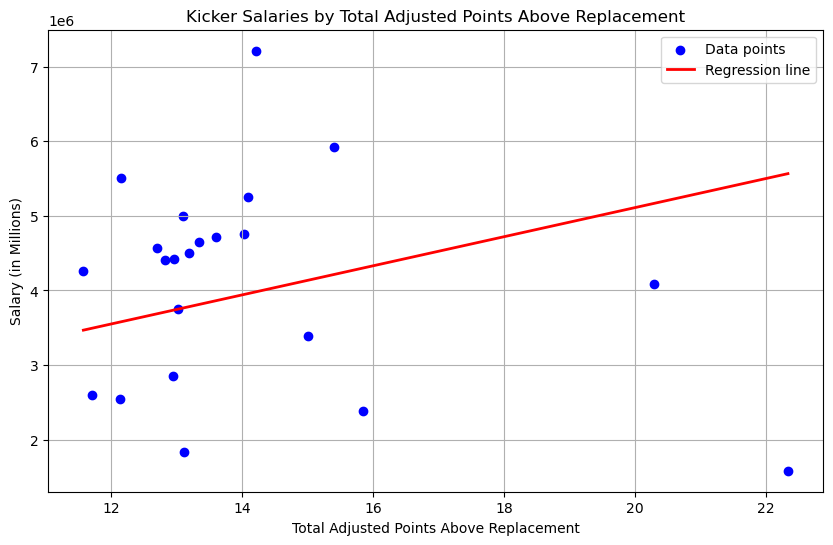

In [15]:
# Conducting regression analysis on how kickers get paid when they hit free agency. Imperfect fit with r^2 of .22 but a 
# good starting point to see how performance affect kicker compensation.

league_minimum = 1210000

veteran_kickers = kicker_salaries_clean.loc[(kicker_salaries_clean['salary_clean'] >= league_minimum)].reset_index(drop=True)

X = veteran_kickers[['Total_Adjusted_Points_Above_Replacement']].values
Y = veteran_kickers['salary_clean']

y_adjusted = Y - league_minimum

model = LinearRegression(fit_intercept=False)
model.fit(X, y_adjusted)

Y_pred = model.predict(X) + league_minimum

ss_total = np.sum((Y - np.mean(Y)) ** 2)
ss_residual = np.sum((Y - Y_pred) ** 2)
r2 = 1 - (ss_residual / ss_total)

print(f"R-squared: {r2}")

plt.figure(figsize=(10, 6))

plt.scatter(X, Y, color='blue', label='Data points')

plt.plot(X, Y_pred, color='red', linewidth=2, label='Regression line')

plt.title('Kicker Salaries by Total Adjusted Points Above Replacement')
plt.xlabel('Total Adjusted Points Above Replacement')
plt.ylabel('Salary (in Millions)')
plt.legend()
plt.grid(True)
plt.show()

In [16]:
# Coefficient in Regression formula to see how much teams pay in free agency for each Adjusted Point Above Replacement

print(model.coef_[0])

194981.37749901778


In [17]:
#Plugging Brandon Aubrey's performance into the regression performed above.

brandon_aubrey_points = [kicker_salaries_clean.loc[(kicker_salaries_clean['Kicker_Name'] == 'B.AUBREY')]['Total_Adjusted_Points_Above_Replacement']]
print((model.predict(brandon_aubrey_points) + league_minimum)[0])

5041209.9317382965


In [18]:
#Kickers sorted by their Adjusted FG %

kicker_salaries_clean.sort_values(by = 'Adjusted_FG_%', ascending=False).reset_index(drop=True)

,Kicker_Name,FG_Makes,expected_Pts,actual_Pts,Residual_Points,FG_Attempts,FG_%,Points_Per_FGA,Expected_Points_Per_FGA,Points_Per_FGA_Above_Expected,Adjusted_Points_Per_FGA,Adjusted_FG_%,Points_Per_Season_Prorated,Adjusted_Points_Per_Season_Prorated,XP_Makes,XP_Attempts,Kick_%,ExtraPoints_Per_Season_Prorated,Total_Adjusted_Points,Adjusted_Points_Per_Season_Prorated_Above_Replacement,ExtraPoints_Per_Season_Prorated_Above_Replacement,Total_Adjusted_Points_Above_Replacement,salary_clean,$_Per_TAPAR
0,C.DICKER,47.0,126.628379,141.0,14.371621,50.0,0.940000,2.820000,2.532568,0.287432,2.811542,0.937181,87.420000,87.157800,51.0,51.0,1.000000,36.500000,123.657800,18.408138,3.926897,22.335035,1585000.0,70964.742168
1,B.AUBREY,35.0,95.057448,105.0,9.942552,37.0,0.945946,2.837838,2.569120,0.268718,2.792827,0.930942,87.972973,86.577641,49.0,52.0,0.942308,34.394231,120.971871,17.827980,1.821127,19.649107,915000.0,46567.001963
2,J.TUCKER,277.0,757.386121,831.0,73.613879,305.0,0.908197,2.724590,2.483233,0.241357,2.765466,0.921822,84.462295,85.729461,348.0,354.0,0.983051,35.881356,121.610817,16.979800,3.308252,20.288052,4082500.0,201226.809383
3,E.MCPHERSON,74.0,210.922583,222.0,11.077417,88.0,0.840909,2.522727,2.396848,0.125880,2.649989,0.883330,78.204545,82.149666,118.0,123.0,0.959350,35.016260,117.165927,13.400005,2.443157,15.843162,2390928.0,150912.299059
4,M.GAY,122.0,349.068337,366.0,16.931663,140.0,0.871429,2.614286,2.493345,0.120940,2.645050,0.881683,81.042857,81.996548,157.0,165.0,0.951515,34.730303,116.726851,13.246887,2.157200,15.404087,5920000.0,384313.595343
5,H.BUTKER,191.0,547.360201,573.0,25.639799,214.0,0.892523,2.677570,2.557758,0.119812,2.643922,0.881307,83.004673,81.961571,290.0,308.0,0.941558,34.366883,116.328454,13.211910,1.793780,15.005689,3388796.0,225834.074555
6,G.GANO,197.0,566.947946,591.0,24.052054,228.0,0.864035,2.592105,2.486614,0.105491,2.629601,0.876534,80.355263,81.517630,220.0,236.0,0.932203,34.025424,115.543053,12.767969,1.452320,14.220289,7211667.0,507139.274116
7,K.FAIRBAIRN,169.0,490.478448,507.0,16.521552,194.0,0.871134,2.613402,2.528239,0.085163,2.609272,0.869757,81.015464,80.887436,195.0,214.0,0.911215,33.259346,114.146782,12.137775,0.686242,12.824017,4401711.0,343239.631222
8,E.PINEIRO,77.0,224.001219,231.0,6.998781,88.0,0.875000,2.625000,2.545468,0.079532,2.603641,0.867880,81.375000,80.712874,70.0,78.0,0.897436,32.756410,113.469284,11.963213,0.183307,12.146520,2545000.0,209525.036182
9,Y.KOO,138.0,401.444073,414.0,12.555927,159.0,0.867925,2.603774,2.524805,0.078968,2.603078,0.867693,80.716981,80.695405,137.0,144.0,0.951389,34.725694,115.421100,11.945744,2.152591,14.098335,5250000.0,372384.391047


In [19]:
#Kickers sorted by their Total Adjusted Points

kicker_salaries_clean.sort_values(by = 'Total_Adjusted_Points', ascending=False).reset_index(drop=True)

,Kicker_Name,FG_Makes,expected_Pts,actual_Pts,Residual_Points,FG_Attempts,FG_%,Points_Per_FGA,Expected_Points_Per_FGA,Points_Per_FGA_Above_Expected,Adjusted_Points_Per_FGA,Adjusted_FG_%,Points_Per_Season_Prorated,Adjusted_Points_Per_Season_Prorated,XP_Makes,XP_Attempts,Kick_%,ExtraPoints_Per_Season_Prorated,Total_Adjusted_Points,Adjusted_Points_Per_Season_Prorated_Above_Replacement,ExtraPoints_Per_Season_Prorated_Above_Replacement,Total_Adjusted_Points_Above_Replacement,salary_clean,$_Per_TAPAR
0,C.DICKER,47.0,126.628379,141.0,14.371621,50.0,0.940000,2.820000,2.532568,0.287432,2.811542,0.937181,87.420000,87.157800,51.0,51.0,1.000000,36.500000,123.657800,18.408138,3.926897,22.335035,1585000.0,70964.742168
1,J.TUCKER,277.0,757.386121,831.0,73.613879,305.0,0.908197,2.724590,2.483233,0.241357,2.765466,0.921822,84.462295,85.729461,348.0,354.0,0.983051,35.881356,121.610817,16.979800,3.308252,20.288052,4082500.0,201226.809383
2,B.AUBREY,35.0,95.057448,105.0,9.942552,37.0,0.945946,2.837838,2.569120,0.268718,2.792827,0.930942,87.972973,86.577641,49.0,52.0,0.942308,34.394231,120.971871,17.827980,1.821127,19.649107,915000.0,46567.001963
3,E.MCPHERSON,74.0,210.922583,222.0,11.077417,88.0,0.840909,2.522727,2.396848,0.125880,2.649989,0.883330,78.204545,82.149666,118.0,123.0,0.959350,35.016260,117.165927,13.400005,2.443157,15.843162,2390928.0,150912.299059
4,M.GAY,122.0,349.068337,366.0,16.931663,140.0,0.871429,2.614286,2.493345,0.120940,2.645050,0.881683,81.042857,81.996548,157.0,165.0,0.951515,34.730303,116.726851,13.246887,2.157200,15.404087,5920000.0,384313.595343
5,H.BUTKER,191.0,547.360201,573.0,25.639799,214.0,0.892523,2.677570,2.557758,0.119812,2.643922,0.881307,83.004673,81.961571,290.0,308.0,0.941558,34.366883,116.328454,13.211910,1.793780,15.005689,3388796.0,225834.074555
6,G.GANO,197.0,566.947946,591.0,24.052054,228.0,0.864035,2.592105,2.486614,0.105491,2.629601,0.876534,80.355263,81.517630,220.0,236.0,0.932203,34.025424,115.543053,12.767969,1.452320,14.220289,7211667.0,507139.274116
7,Y.KOO,138.0,401.444073,414.0,12.555927,159.0,0.867925,2.603774,2.524805,0.078968,2.603078,0.867693,80.716981,80.695405,137.0,144.0,0.951389,34.725694,115.421100,11.945744,2.152591,14.098335,5250000.0,372384.391047
8,M.PRATER,222.0,645.428531,666.0,20.571469,264.0,0.840909,2.522727,2.444805,0.077922,2.602032,0.867344,78.204545,80.662984,288.0,303.0,0.950495,34.693069,115.356053,11.913322,2.119966,14.033288,4759765.0,339176.741159
9,C.BOSWELL,218.0,635.891522,654.0,18.108478,251.0,0.868526,2.605578,2.533432,0.072145,2.596255,0.865418,80.772908,80.483900,268.0,284.0,0.943662,34.443662,114.927562,11.734238,1.870559,13.604797,4720000.0,346936.451755
